### Импорт необходимых библиотек

In [1]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from tqdm import tqdm
import sys

In [2]:
# константы
TRAIN_PATH = 'C:\\Users\\sasha\\PycharmProjects\\CourseVSHE\\kaggle_project\\train'
TEST_PATH = 'C:\\Users\\sasha\\PycharmProjects\\CourseVSHE\\kaggle_project\\test'
ADD_TRAIN = 'C:\\Users\\sasha\\PycharmProjects\\CourseVSHE\\kaggle_project\\train_new'
BATCH = 16
RESIZING_SIZE = 512
CROP_SIZE = 488
MEAN = [0.485, 0.456, 0.406] # ImageNet
STD = [0.229, 0.224, 0.225] # ImageNet
SEED = 0
SLASH = '\\'

### Используемые функции

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
# функция для создания копий изображений для того, чтобы уравновесить количество
# объектов в выборках разных классов
def create_copy_of_images(train_folders, label, diff, train_folders_len):
    
    for train_folder in train_folders:
        if train_folder.split(SLASH)[-1] == label:
            path = train_folder
            
    save_folder = ADD_TRAIN + SLASH + path.split(SLASH)[-1]
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    for i in range(diff):
        length_of_folder = train_folders_len[label]
        random_num = np.random.randint(length_of_folder)
    
        all_images = os.listdir(path)
        random_image = all_images[random_num]
        base, ext = os.path.splitext(random_image)
        copy_image = base + '_' + str(i) + ext
        original_path = path + SLASH + random_image
        new_path = save_folder + SLASH + copy_image 
        shutil.copy(original_path, new_path)

In [5]:
# создание списков на основании папки, где находятся изображения;
# списки будут содержать полный путь к изображению и его класс 
def to_pandas_dataframe(train_folders):
    paths_to_images = []
    labels = []

    for folder in train_folders:
        label = folder.split(SLASH)[-1]
        all_images = os.listdir(folder)
        for image in all_images:
            image = folder + SLASH + image
            paths_to_images.append(image)
            labels.append(label)
    return paths_to_images, labels

In [6]:
# функция обучения модели
def train(model, dataloader, device, optimizer, criterion):
    
    model = model.to(device).train()
    
    losses_per_batch = []
    accuracy_per_batch = []
    accuracy_for_all = []
    
    total_labels = np.array([])
    total_predictions = np.array([])
    
    with tqdm(total=len(dataloader), file=sys.stdout) as prbar:
        
        for images, labels in dataloader:
            
            # обучение модели
            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            preds = model(images)
            
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            
            # подсчет метрик (в данном случае точности)
            total_predictions = np.append(
                total_predictions, 
                preds.argmax(1).cpu().detach().numpy(),
                )
            total_labels = np.append(
                total_labels, 
                labels.cpu().detach().numpy(),
                )
            
            accuracy_total = accuracy_score(total_labels, total_predictions)
            accuracy_batch = accuracy_score(
                labels.cpu().detach().numpy(), 
                preds.argmax(1).cpu().detach().numpy()
            )
            
            prbar.set_description(
                f'Loss: {round(loss.item(), 4)} '
                f'Accuracy: {round(accuracy_total, 4)} '
                f'Accuracy_batch: {round(accuracy_batch, 4)}'
            )
            prbar.update(1)

            losses_per_batch.append(loss.detach().item())
            accuracy_per_batch.append(accuracy_batch)
            accuracy_for_all.append(accuracy_total)
            
    return losses_per_batch, accuracy_per_batch, accuracy_for_all

In [7]:
# функция валидации модели
def validate(model, dataloader, device, criterion):
    
    model = model.to(device).eval()
    
    losses_per_batch = []
    accuracy_per_batch = []
    accuracy_for_all = []
    
    total_labels = np.array([])
    total_predictions = np.array([])
    
    with tqdm(total=len(dataloader), file=sys.stdout) as prbar:
        
        with torch.no_grad():
            
            for images, labels in dataloader:
                
                # валидация
                images = images.to(device)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
                preds = model(images)

                loss = criterion(preds, labels)
                
                # подсчет метрик (в данном случае точности)
                total_predictions = np.append(
                    total_predictions, 
                    preds.argmax(1).cpu().detach().numpy(),
                    )
                total_labels = np.append(
                    total_labels, 
                    labels.cpu().detach().numpy(),
                    )
            
                accuracy_total = accuracy_score(total_labels, total_predictions)
                accuracy_batch = accuracy_score(
                    labels.cpu().detach().numpy(), 
                    preds.argmax(1).cpu().detach().numpy()
                )
            
                prbar.set_description(
                    f'Loss: {round(loss.item(), 4)} '
                    f'Accuracy: {round(accuracy_total, 4)} '
                    f'Accuracy_batch: {round(accuracy_batch, 4)}'
                )
                prbar.update(1)

                losses_per_batch.append(loss.detach().item())
                accuracy_per_batch.append(accuracy_batch)
                accuracy_for_all.append(accuracy_total)
    
    return losses_per_batch, accuracy_per_batch, accuracy_for_all

In [8]:
# общая функция для совместного обучения и валидации модели
def fit_model(model, epochs, train_dataloader, val_dataloader, optimizer, criterion, device, scheduler=None):
    
    losses_train = np.array([])
    losses_valid = np.array([])

    accuracy_train = []
    accuracy_valid = []
    
    for epoch in range(epochs):

        print(f'Train epoch: {epoch}')

        # обучение модели
        losses_per_batch_train, accuracy_per_batch_train, accuracy_for_all_train = train(
            model, 
            train_dataloader, 
            device, 
            optimizer,
            criterion
        )
        
        # сохранение результатов обучения
        losses_train = np.append(losses_train, np.array(losses_per_batch_train))
        accuracy_train.append(accuracy_for_all_train[-1])

        print(f'Validation epoch: {epoch}')
        
        # валидация модели
        losses_per_batch_val, accuracy_per_batch_val, accuracy_for_all_val = validate(
            model, 
            val_dataloader, 
            device,
            criterion)
        
        # сохранение результатов валидации
        losses_valid = np.append(losses_valid, np.array(losses_per_batch_val))
        accuracy_valid.append(accuracy_for_all_val[-1])
    
    return losses_train, losses_valid, accuracy_train, accuracy_valid

In [9]:
# получение предсказаний модели на основании полученных изображений
def predict(model, train_dataset, TEST_PATH, test_dataloader, device):
    
    true_labels = train_dataset.get_classes_indices()
    ids = []
    classes = []
    
    image_ids = os.listdir(TEST_PATH)
    index_of_image = 0
    
    with torch.no_grad():
        
        for images in tqdm(test_dataloader):
        
            for image in images:
            
                image = image.to(device)
                prediction = model(image.unsqueeze(0))
                prediction = true_labels[prediction.argmax(1).cpu().detach().numpy()[0]]
                id_of_image, _ = os.path.splitext(image_ids[index_of_image])
                ids.append(id_of_image)
                classes.append(prediction)
                index_of_image += 1
                
    prediction_results = pd.DataFrame({'id': ids, 'class': classes})
    
    return prediction_results

### Анализ изображений, создание обучающего и валидационного датасетов

In [10]:
set_seed(SEED)

Для начала рассмотрим распределение классов среди изображений обучающей выборки.

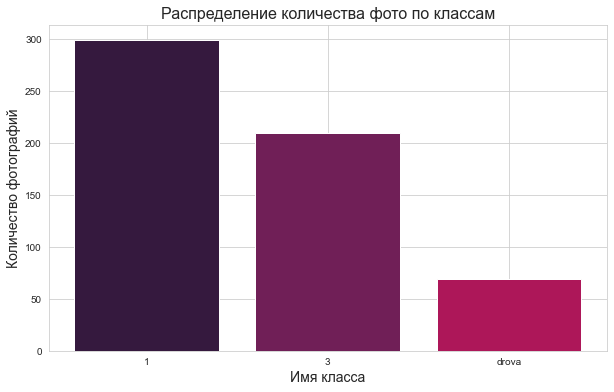

In [11]:
train_folders = [f.path for f in os.scandir(TRAIN_PATH) if f.is_dir()]

sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('rocket'))
plt.figure(figsize=(10, 6))

train_folders_len = dict()

for folder in train_folders:
    class_name = folder.split(SLASH)[-1]
    plt.bar(x=class_name, height=len(os.listdir(folder)))
    train_folders_len[class_name] = len(os.listdir(folder))

plt.xlabel('Имя класса', fontsize=14)
plt.ylabel('Количество фотографий', fontsize=14)
plt.title('Распределение количества фото по классам', fontsize=16)
plt.show()

Как можно отметить, классы несколько несбалансированы. Потому, необходимо дополнить датасет новыми изображениями, а точнее, копиями первоначальных. Это даст возможность убрать проблему дисбаланса классов, а при помощи аугментации изображений получится несколько невилировать эффект нахождения одинаковых изображений в выборке.

In [12]:
max_num_of_photos = train_folders_len['1']
diff_3 = max_num_of_photos - train_folders_len['3']
diff_drova = max_num_of_photos - train_folders_len['drova']

create_copy_of_images(train_folders, '3', diff_3, train_folders_len)
create_copy_of_images(train_folders, 'drova', diff_drova, train_folders_len)

Теперь посмотрим на сами изображения.

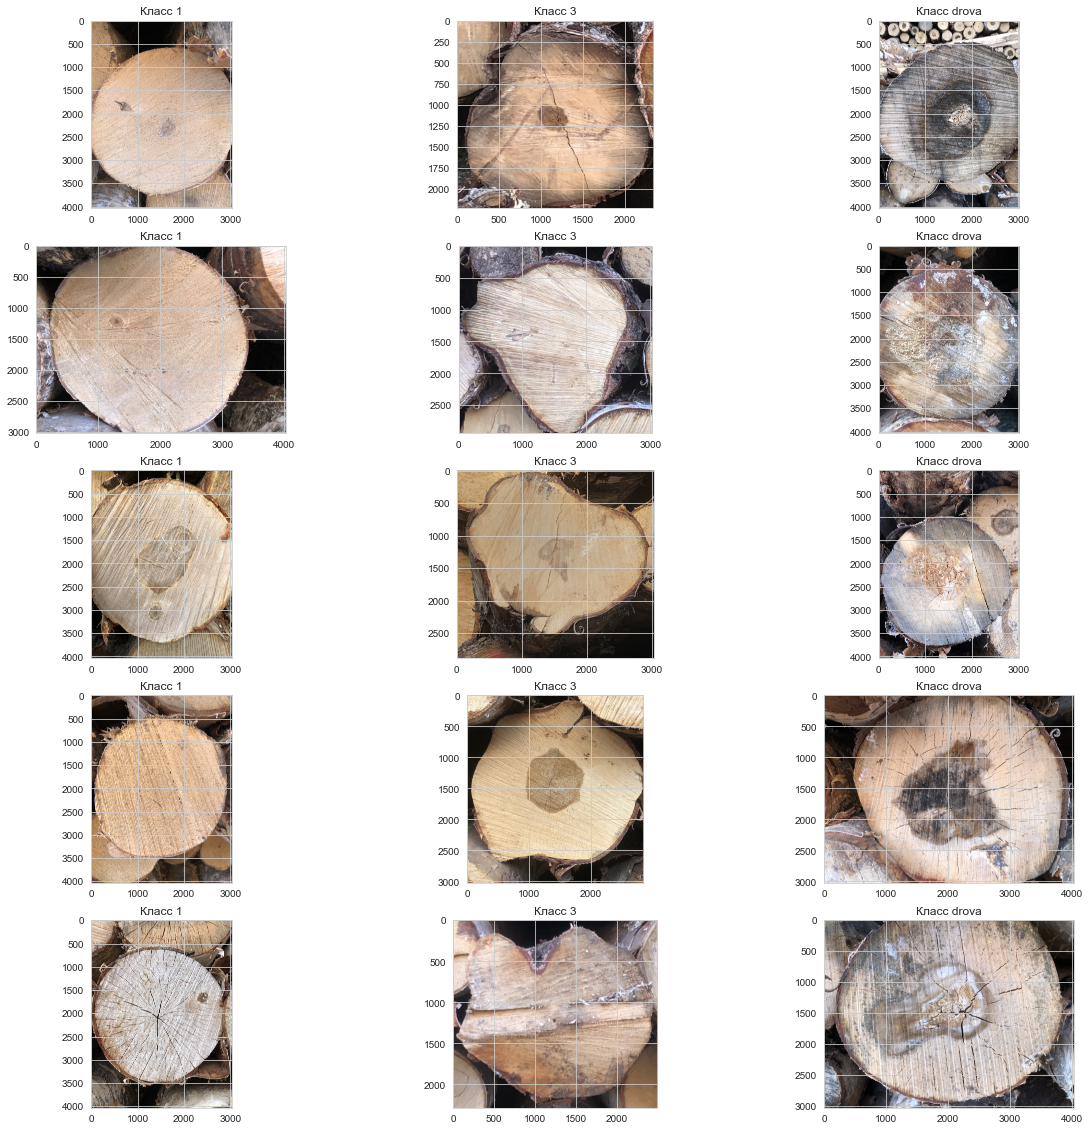

In [13]:
nrows = BATCH // len(train_folders)
ncols = len(train_folders)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))

for row in range(nrows):
    
    for train_folder, col in zip(train_folders, range(ncols)):
        
        all_images = os.listdir(train_folder)
        random_img_num = np.random.randint(len(all_images))
        random_image = all_images[random_img_num]
        axes[row, col].imshow(Image.open(train_folder + SLASH + random_image))
        title = train_folder.split(SLASH)[-1]
        axes[row, col].set_title(f'Класс {title}')

Следует создать трансформеры, которые и будут проводить аугментацию изображений. Для обучающей и валидационной выборки будут созданы два разных трансформера, так как нам не следует применять рандомные аугментации на валидации или тесте.

In [14]:
transformer_train = transforms.Compose(
    [
     transforms.Resize(
         (RESIZING_SIZE, RESIZING_SIZE),
         ),
     transforms.CenterCrop(
         (CROP_SIZE, CROP_SIZE)
         ),
     transforms.RandomPerspective(
         distortion_scale=0.1,
         p=0.3,
         ),
     transforms.RandomRotation(
         degrees=(-30, 30),
         ),
     transforms.RandomAdjustSharpness(
         sharpness_factor=1.5,
         p=0.5,
         ),
     transforms.ToTensor(),
     transforms.Normalize(
         mean=MEAN,
         std=STD,
         ),
     ],
)

In [15]:
transformer_valid = transforms.Compose(
    [
     transforms.Resize(
         (RESIZING_SIZE, RESIZING_SIZE),
         ),
     transforms.CenterCrop(
         (CROP_SIZE, CROP_SIZE)
         ),
     transforms.ToTensor(),
     transforms.Normalize(
         mean=MEAN,
         std=STD,
         ),
     ],
)

Создадим объект DataFrame для более наглядного и легкого получения путей изображений и их меток.

In [16]:
paths_to_images, labels = to_pandas_dataframe(train_folders)
original_train = pd.DataFrame({'image_path': paths_to_images, 'labels': labels})
paths_to_images, labels = to_pandas_dataframe(
    [ADD_TRAIN + SLASH + path for path in os.listdir(ADD_TRAIN)]
)
additional_train = pd.DataFrame({'image_path': paths_to_images, 'labels': labels})

In [17]:
train_data = pd.concat(
    (original_train, additional_train), 
    axis=0).reset_index(drop=True)

train_data

,image_path,labels
0,C:\Users\sasha\PycharmProjects\CourseVSHE\kagg...,1
1,C:\Users\sasha\PycharmProjects\CourseVSHE\kagg...,1
2,C:\Users\sasha\PycharmProjects\CourseVSHE\kagg...,1
3,C:\Users\sasha\PycharmProjects\CourseVSHE\kagg...,1
4,C:\Users\sasha\PycharmProjects\CourseVSHE\kagg...,1
...,...,...
892,C:\Users\sasha\PycharmProjects\CourseVSHE\kagg...,drova
893,C:\Users\sasha\PycharmProjects\CourseVSHE\kagg...,drova
894,C:\Users\sasha\PycharmProjects\CourseVSHE\kagg...,drova
895,C:\Users\sasha\PycharmProjects\CourseVSHE\kagg...,drova


Поделим изображения на обучение и валидацию.

In [18]:
X = train_data['image_path']
y = train_data['labels']
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    shuffle=True,
    random_state=241
)

Теперь, для того, чтобы применить к изображениям аугментацию и при том использовать их в последующем в DataLoader с батчами, нужно определить новый класс, который бы позволял итерироваться по датасету и трансформировать по одному объекту в нем. Помимо этого, для того, чтобы метки класса корректно определялись моделью, переведем их с помощью LabelEncoder в числовые значения.

In [19]:
class WoodDataset(Dataset):
    
    def __init__(self, images_path, labels=None, transformer=None):
        
        self.images_path = images_path
        self.label_encoder = LabelEncoder()
        
        if labels is not None:
            self.labels = self.label_encoder.fit_transform(labels)
        else:
            self.labels = None
        
        self.transformer = transformer
    
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        
        img_path = self.images_path[idx]
        image = Image.open(img_path)
        
        if self.transformer:
            image = self.transformer(image)
        
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image
        
    def get_classes_indices(self):
        return self.label_encoder.classes_

Наконец, можно создать датасеты для обучения и валидации, а в последующем определить для них соответствующий DataLoader.

In [20]:
train_dataset = WoodDataset(
    images_path=X_train.reset_index(drop=True), 
    labels=y_train.reset_index(drop=True), 
    transformer=transformer_train,
)
val_dataset = WoodDataset(
    images_path=X_val.reset_index(drop=True), 
    labels=y_val.reset_index(drop=True), 
    transformer=transformer_valid,
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH, shuffle=True)

Дополнительно посмотрим на то, как изменились изображения после аугментации.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

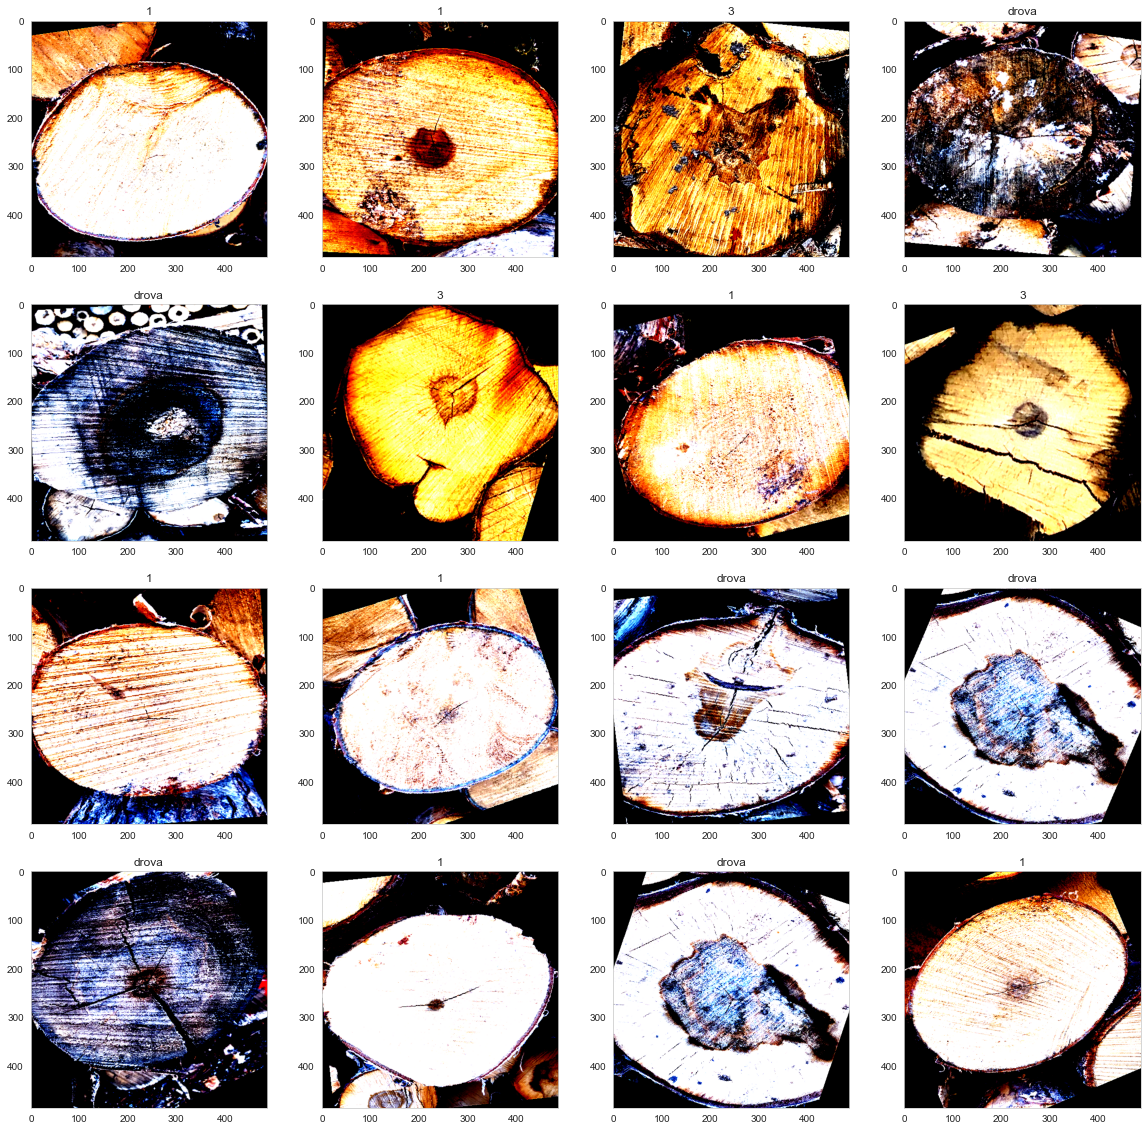

In [21]:
images, labels = next(iter(train_dataloader))

nrows = int(len(labels) ** 0.5)
ncols = int(len(labels) ** 0.5)
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))

character_labels = train_dataset.get_classes_indices()
index = 0
for row in range(nrows):
    for col in range(ncols):
        if index  == len(labels):
            break
        axes[row, col].imshow(images[index].numpy().transpose((1, 2, 0)))
        axes[row, col].set_title(character_labels[labels[index]])
        axes[row, col].grid(False)
        index += 1

### Обучение модели, получение предсказаний

В рамках данной работы моделью будет выбрана resnet18, самая простая из данного класса. 

Избранная модель будет предобучена - это позволит более лучшим образом обучить модель на основе нашего небольшого датасета и не слишком переобучиться, вдобавок, позволит и сократить время обучения.

Также, 6 первоначальных слоев модели будут заморожены. Будут обучаться лишь последние 4 слоя (2 слоя со свертками, 1 слой с пулингом, 1 полносвязный слой). 

In [22]:
model = torchvision.models.resnet18(pretrained=True)

for index, child in enumerate(model.children()):
    
    if index < 6:
        
        for param in child.parameters():
            
            param.requires_grad = False
            
    index += 1

model.fc = nn.Linear(512, len(train_folders))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=1e-4)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [23]:
losses_train, losses_valid, accuracy_train, accuracy_valid = fit_model(
    model, 
    6, 
    train_dataloader, 
    val_dataloader, 
    optimizer, 
    criterion, 
    device
)

Train epoch: 0
Loss: 0.4462 Accuracy: 0.8485 Accuracy_batch: 0.6667: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [03:02<00:00,  4.56s/it]
Validation epoch: 0
Loss: 0.0495 Accuracy: 0.9704 Accuracy_batch: 1.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:14<00:00,  4.36s/it]
Train epoch: 1
Loss: 0.2707 Accuracy: 0.9633 Accuracy_batch: 1.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:57<00:00,  4.44s/it]
Validation epoch: 1
Loss: 0.0085 Accuracy: 0.9704 Accuracy_batch: 1.0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Посмотрим на лоссы на обучении и на валидации.

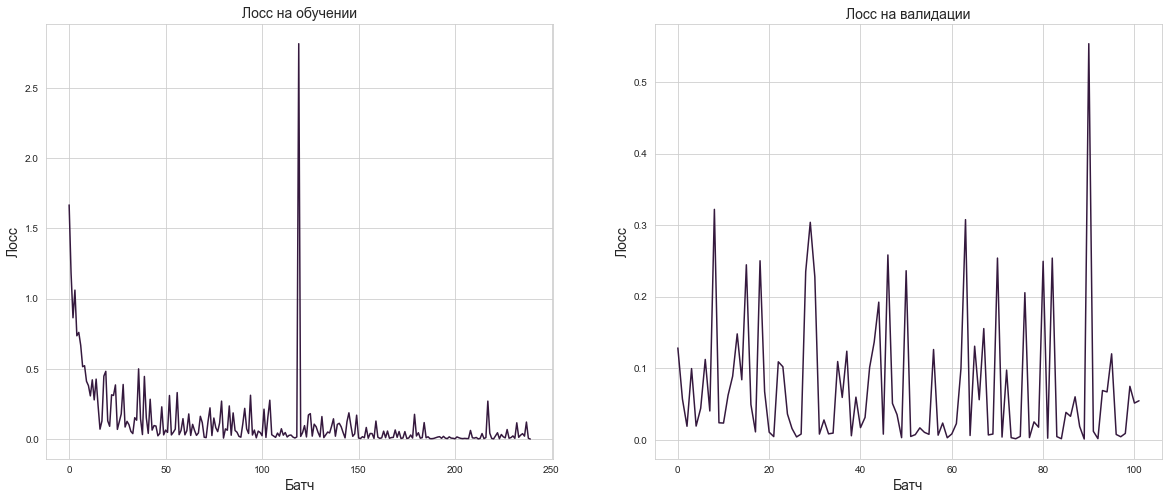

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

x = np.arange(0, len(losses_train))
axes[0].plot(x, losses_train)
axes[0].set_xlabel('Батч', fontsize=14)
axes[0].set_ylabel('Лосс', fontsize=14)
axes[0].set_title('Лосс на обучении', fontsize=14)

x = np.arange(0, len(losses_valid))
axes[1].plot(x, losses_valid)
axes[1].set_xlabel('Батч', fontsize=14)
axes[1].set_ylabel('Лосс', fontsize=14)
axes[1].set_title('Лосс на валидации', fontsize=14)
plt.show()

Как можно заметить, лосс на обучении с увеличением количества батчей так или иначе уменьшается. То же нельзя сказать про ситуацию на валидации - здесь лосс "вскакивает" на некоторых батчах, хотя и общий лосс порой не столь значительный. Это говорит о том, что модель еще не до конца обучилась (скорее, переобучилась), хотя и не критично. Возможно, стоит изменить количество эпох обучения или же добавить больше изображений в выборку.

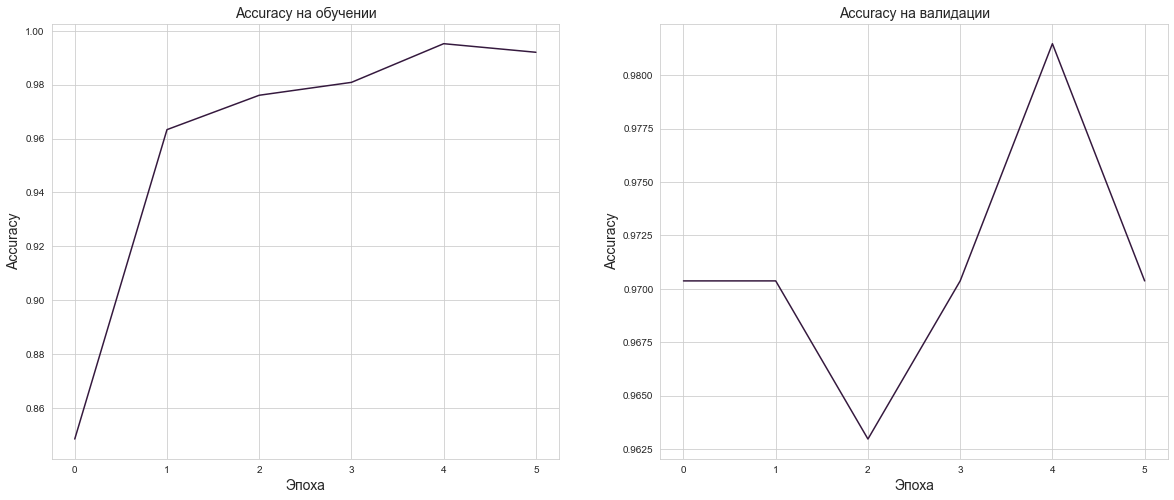

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

x = np.arange(0, len(accuracy_train))
axes[0].plot(x, accuracy_train)
axes[0].set_xlabel('Эпоха', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].set_title('Accuracy на обучении', fontsize=14)

x = np.arange(0, len(accuracy_valid))
axes[1].plot(x, accuracy_valid)
axes[1].set_xlabel('Эпоха', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].set_title('Accuracy на валидации', fontsize=14)
plt.show()

С долей правильных ответов та же ситуация, что и с лоссом.

In [31]:
image_paths_test = []
for image in os.listdir(TEST_PATH):
    image_paths_test.append(TEST_PATH + SLASH + image)

Наконец, предскажем значения для тестовой выборки.

In [32]:
test_dataset = WoodDataset(
    images_path=image_paths_test,
    transformer=transformer_valid,
)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

In [34]:
prediction_results = predict(model, train_dataset, TEST_PATH, test_dataloader, device)
prediction_results['class'].replace({'drova': 0}, inplace=True)
prediction_results.to_csv('submission_final.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:10<00:00,  4.38s/it]
